In [1]:
%load_ext autoreload
%autoreload 2
import notebook_setup
from src.config import INTERIM_DATA_DIR, PROCESSED_DATA_DIR, REPORTS_DIR, EXTERNAL_DATA_DIR, MODELS_DIR
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["MKL_NUM_THREADS"] = "4"

2025-09-22 23:13:41.136 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: D:\workspace\projects\freelance\Fusion3DNet


Project root added to path: d:\workspace\projects\freelance\Fusion3DNet


Using STEP file: D:\workspace\projects\freelance\Fusion3DNet\data\processed\dataset_129\stp\43. Extractor-06.prt.stp


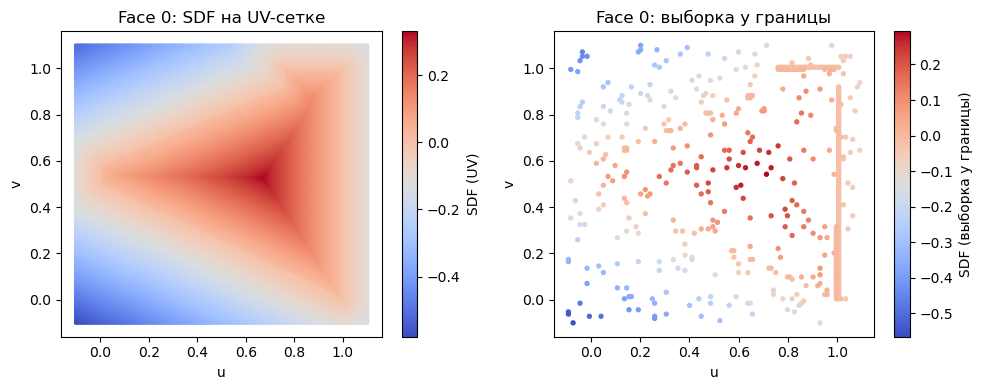

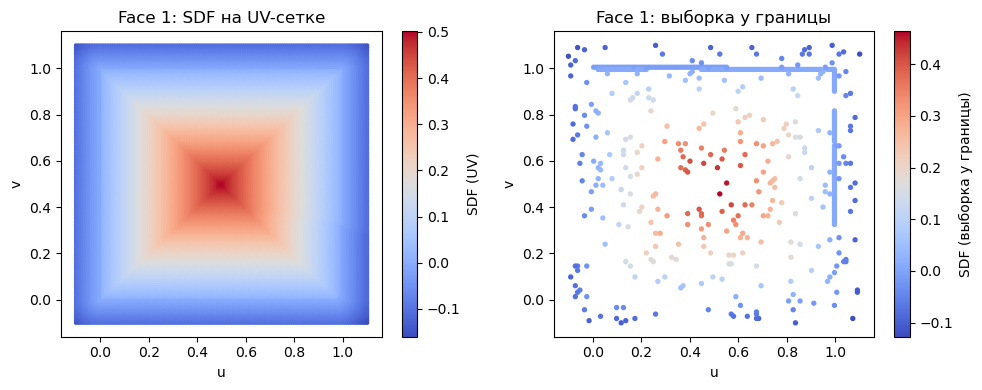

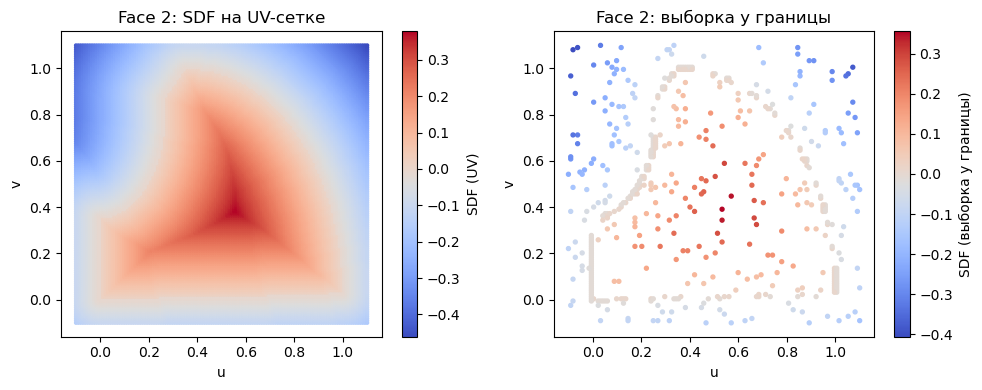

Граней: 53; всего SDF-точек на сетках: [ 0.02834646  0.02834646  0.02834646 ... -0.71747947 -0.73604894
 -0.7554252 ]; выборок у границы на грань: 500


In [2]:
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

# OCC
from OCC.Core.STEPControl import STEPControl_Reader
from OCC.Core.IFSelect import IFSelect_RetDone
from OCC.Core.TopExp import TopExp_Explorer
from OCC.Core.TopAbs import TopAbs_FACE, TopAbs_IN
from OCC.Core.BRepAdaptor import BRepAdaptor_Surface
from OCC.Core.BRepClass import BRepClass_FaceClassifier
from OCC.Core.gp import gp_Pnt2d

def ensure_uv_2d(x):
    x = np.asarray(x, dtype=np.float32)
    if x.size == 0:
        return np.zeros((0, 2), dtype=np.float32)
    if x.ndim == 2 and x.shape[1] == 2:
        return x
    if x.ndim == 1 and x.shape[0] == 2:
        return x.reshape(1, 2)
    return x.reshape(-1, 2)

def sample_uv_extended(resolution, extend=0.1):
    u = np.linspace(-extend, 1 + extend, resolution)
    v = np.linspace(-extend, 1 + extend, resolution)
    uu, vv = np.meshgrid(u, v, indexing='ij')
    return np.stack([uu.flatten(), vv.flatten()], axis=-1)

def compute_sdf(inside_points, outside_points):
    inside = ensure_uv_2d(inside_points)
    outside = ensure_uv_2d(outside_points)

    if inside.shape[0] == 0 and outside.shape[0] == 0:
        return np.zeros((0, 2), dtype=np.float32), np.zeros((0,), dtype=np.float32)
    if inside.shape[0] == 0:
        return outside, -np.zeros((outside.shape[0],), dtype=np.float32)
    if outside.shape[0] == 0:
        return inside, np.zeros((inside.shape[0],), dtype=np.float32)

    inside_tree = KDTree(outside)
    outside_tree = KDTree(inside)
    d_inside, _ = inside_tree.query(inside)
    d_outside, _ = outside_tree.query(outside)

    sdf_inside = d_inside.astype(np.float32)
    sdf_outside = -d_outside.astype(np.float32)
    sdf_points = np.concatenate([inside, outside], axis=0)
    sdf_values = np.concatenate([sdf_inside, sdf_outside], axis=0)
    return ensure_uv_2d(sdf_points), sdf_values.astype(np.float32)

def bias_sample_sdf(sdf_points, sdf_values, n_samples, boundary_ratio=0.4):
    pts = ensure_uv_2d(sdf_points)
    vals = np.asarray(sdf_values, dtype=np.float32).reshape(-1)
    if pts.shape[0] == 0:
        return pts, vals
    idx = np.argsort(np.abs(vals))
    nb = int(n_samples * boundary_ratio)
    nb = max(0, min(nb, idx.size))
    i_boundary = idx[:nb]
    i_pool = idx[nb:]
    if i_pool.size:
        i_pool = np.random.permutation(i_pool)
    need_rand = max(0, n_samples - nb)
    i_sel = np.concatenate([i_boundary, i_pool[:min(need_rand, i_pool.size)]], axis=0)
    i_sel = i_sel.astype(int)
    return pts[i_sel], vals[i_sel]

# ---------- привязка к реальной грани ----------
def query_cad_kernel_face(face, uv_samples):
    """
    Делим UV на inside/outside относительно ТРИМОВ грани через CAD-ядро.
    """
    uv = ensure_uv_2d(uv_samples)
    surf = BRepAdaptor_Surface(face)
    u0, u1 = surf.FirstUParameter(), surf.LastUParameter()
    v0, v1 = surf.FirstVParameter(), surf.LastVParameter()
    clf = BRepClass_FaceClassifier()

    mask = []
    for uv_ in uv:
        uu = float(u0 + float(uv_[0]) * (u1 - u0))
        vv = float(v0 + float(uv_[1]) * (v1 - v0))
        p2d = gp_Pnt2d(uu, vv)
        clf.Perform(face, p2d, 1e-9)
        mask.append(clf.State() == TopAbs_IN)

    mask = np.array(mask, dtype=bool)
    inside  = uv[mask]
    outside = uv[~mask]
    return ensure_uv_2d(inside), ensure_uv_2d(outside)

def compute_xyz_from_uv_face(face, uv_coords):
    uv = ensure_uv_2d(uv_coords)
    if uv.shape[0] == 0:
        return np.zeros((0, 3), dtype=np.float32)
    surf = BRepAdaptor_Surface(face)
    u0, u1 = surf.FirstUParameter(), surf.LastUParameter()
    v0, v1 = surf.FirstVParameter(), surf.LastVParameter()
    uu = u0 + uv[:, 0] * (u1 - u0)
    vv = v0 + uv[:, 1] * (v1 - v0)
    out = np.zeros((uv.shape[0], 3), dtype=np.float32)
    for i in range(uv.shape[0]):
        p = surf.Value(float(uu[i]), float(vv[i]))
        out[i, 0] = p.X(); out[i, 1] = p.Y(); out[i, 2] = p.Z()
    return out

# ---------- загрузка STEP и обход граней ----------
def load_shape(step_path: str):
    r = STEPControl_Reader()
    assert r.ReadFile(step_path) == IFSelect_RetDone, "STEP read failed"
    r.TransferRoots()
    return r.OneShape()
from OCC.Extend import TopologyUtils
def iter_faces(shape):
    top_exp = TopologyUtils.TopologyExplorer(shape, ignore_orientation=True)
    for face in top_exp.faces():
        yield face

# ---------- быстрая проверка на 1-й грани ----------
def quick_sdf_check_all(step_path: str, res=128, extend=0.1, n_samples=500, show_first_k=2):
    shape = load_shape(step_path)
    faces = list(iter_faces(shape))
    assert len(faces) > 0, "Нет граней в модели"

    all_sdf_uv   = []   # список [ [n_i,2], ... ]
    all_sdf_vals = []   # список [ [n_i],   ... ]
    all_samp_uv  = []   # список [ [n_samples,2], ... ]
    all_samp_sdf = []   # список [ [n_samples],   ... ]
    all_targ_xyz = []   # список [ [n_samples,3], ... ]

    for i, face in enumerate(faces):
        if i >= 3:
            break
        uv = sample_uv_extended(resolution=res, extend=extend)            # [M,2] torch
        inside, outside = query_cad_kernel_face(face, uv)                 # [*,2]
        sdf_pts, sdf_vals = compute_sdf(inside, outside)                  # [M',2],[M']
        samp_uv, samp_sdf = bias_sample_sdf(sdf_pts, sdf_vals,
                                            n_samples=n_samples, boundary_ratio=0.4)
        targ_xyz = compute_xyz_from_uv_face(face, samp_uv)                # [n_samples,3]

        all_sdf_uv.append(sdf_pts)
        all_sdf_vals.append(sdf_vals)
        all_samp_uv.append(samp_uv)
        all_samp_sdf.append(samp_sdf)
        all_targ_xyz.append(targ_xyz)

        # необязательная визуализация для первых k граней
        # if i < show_first_k:
        fig, ax = plt.subplots(1, 2, figsize=(10,4))
        sc = ax[0].scatter(sdf_pts[:,0], sdf_pts[:,1],
                            c=sdf_vals, s=4, cmap="coolwarm")
        fig.colorbar(sc, ax=ax[0], label="SDF (UV)")
        ax[0].set_title(f"Face {i}: SDF на UV-сетке")
        ax[0].set_xlabel("u"); ax[0].set_ylabel("v")

        sc2 = ax[1].scatter(samp_uv[:,0], samp_uv[:,1],
                                c=samp_sdf, s=8, cmap="coolwarm")
        fig.colorbar(sc2, ax=ax[1], label="SDF (выборка у границы)")
        ax[1].set_title(f"Face {i}: выборка у границы")
        ax[1].set_xlabel("u"); ax[1].set_ylabel("v")
        plt.tight_layout(); plt.show()

    # сводка
    total_points = sum(v for v in all_sdf_vals)
    print(f"Граней: {len(faces)}; всего SDF-точек на сетках: {total_points}; "
          f"выборок у границы на грань: {n_samples}")

    return {
        "faces_count": len(faces),
        "sdf_grid_uv_list": all_sdf_uv,        # список torch тензоров [n_i,2]
        "sdf_grid_vals_list": all_sdf_vals,    # список torch тензоров [n_i]
        "sampled_uv_list": all_samp_uv,        # список torch тензоров [n_samples,2]
        "sampled_sdf_list": all_samp_sdf,      # список torch тензоров [n_samples]
        "target_xyz_list": all_targ_xyz        # список torch тензоров [n_samples,3]
    }

STEPS_DIR = PROCESSED_DATA_DIR / "dataset_129" / "stp"

step_files = stems = {p for p in STEPS_DIR.glob("*.stp")}

stp = list(step_files)[15]
print(f"Using STEP file: {stp}")
out = quick_sdf_check_all(str(stp), res=128, extend=0.1, n_samples=500)



In [22]:
from src.modeling.SSL_BrepNet import extract_features

FEATURES_LIST_PATH = EXTERNAL_DATA_DIR / "feature_lists" / "all.json"
STEPS_DIR = PROCESSED_DATA_DIR / "dataset_129" / "stp"
extract_features.run(
    step_path_dir=STEPS_DIR,
    feature_list_path=FEATURES_LIST_PATH,
    num_workers=0,
    force_regeneration=True
)

2025-09-21 13:28:30.564 | INFO     | src.modeling.SSL_BrepNet.extract_features:extract_brepnet_data_from_step:43 - Начало обработки: force_regeneration=True, num_workers=0


100%|██████████| 129/129 [05:12<00:00,  2.42s/it]

2025-09-21 13:33:43.242 | SUCCESS  | src.modeling.SSL_BrepNet.extract_features:extract_brepnet_data_from_step:60 - Обработка завершена.


In [31]:
from src.modeling.SSL_BrepNet import build_dataset_file
BREPNET_NPZ_DIR = PROCESSED_DATA_DIR / "dataset_129" / "features" / "brep"
STATS_BREPNET = PROCESSED_DATA_DIR / "dataset_129" / "dataset_brepnet_stats.json"
os.makedirs(BREPNET_NPZ_DIR, exist_ok=True)
build_dataset_file.run(
    brepnet_dir=BREPNET_NPZ_DIR,
    output_file=STATS_BREPNET,
    validation_split=0.1,
    test_split=0.1,
    random_seed=42,
)

2025-09-21 13:45:13.471 | INFO     | src.modeling.SSL_BrepNet.build_dataset_file:run:88 - Найдено 129 общих моделей.
2025-09-21 13:45:13.471 | INFO     | src.modeling.SSL_BrepNet.build_dataset_file:run:97 - Разделение: 104 train, 12 validation, 13 test.
2025-09-21 13:45:13.471 | INFO     | src.modeling.SSL_BrepNet.build_dataset_file:find_brepnet_standardization:51 - Вычисление статистик стандартизации для B-repNet...


100%|██████████| 104/104 [00:00<00:00, 307.84it/s]

2025-09-21 13:45:13.810 | INFO     | src.modeling.SSL_BrepNet.build_dataset_file:run:114 - 
Файл набора данных успешно создан: G:\Projects\Fusion-3D-CNN\data\processed\dataset_129\dataset_brepnet_stats.json


In [3]:
BREPNET_NPZ_DIR = PROCESSED_DATA_DIR / "dataset_129" / "features" / "brep"
import numpy as np
npz_files = list(BREPNET_NPZ_DIR.glob("*.npz"))
print(f"Всего .npz файлов: {len(npz_files)}")

with np.load(npz_files[3]) as data:
    for k, v in data.items():
        print(f"{k}: {v.shape}, dtype={v.dtype}, min={v.min() if v.size>0 else 'N/A'}, max={v.max() if v.size>0 else 'N/A'}")

# BREPNET_NPZ_DIR = PROCESSED_DATA_DIR / "dataset_129" / "features" / "all_sdf_with_normals"
# npz_files = list(BREPNET_NPZ_DIR.glob("*.npz"))
# print(f"Всего .npz файлов: {len(npz_files)}")

# with np.load(npz_files[0]) as data:
#     for k, v in data.items():
#         print(f"{k}: {v.shape}, dtype={v.dtype}, min={v.min() if v.size>0 else 'N/A'}, max={v.max() if v.size>0 else 'N/A'}")

# os.makedirs(BREPNET_NPZ_DIR, exist_ok=True)

# for npz_path in npz_files:
#     with np.load(npz_path) as data:
#         uv_faces = data['uv_faces']          # [n,2]
#         sdf_faces = data['sdf_faces']    # [n]
#     np.savez_compressed(BREPNET_NPZ_DIR / npz_path.name, uv_faces=uv_faces, sdf_faces=sdf_faces)
#     print(f"Обработан файл {npz_path}, добавлены нормали.")

Всего .npz файлов: 129
face_features: (9, 7), dtype=float64, min=0.0, max=7.339927890980251
face_point_grids: (9, 7, 10, 10), dtype=float64, min=-1.0, max=1.0
edge_features: (16, 10), dtype=float64, min=0.0, max=4.1887900628499
coedge_point_grids: (31, 12, 10), dtype=float64, min=-1.0, max=1.0
coedge_features: (31, 1), dtype=float64, min=0.0, max=1.0
coedge_lcs: (31, 4, 4), dtype=float64, min=-1.0, max=1.0
coedge_scale_factors: (31,), dtype=float64, min=1.1111111487609353, max=2.000000068812871
coedge_reverse_flags: (31,), dtype=float64, min=0.0, max=1.0
next: (31,), dtype=uint32, min=0, max=30
mate: (31,), dtype=uint32, min=0, max=30
face: (31,), dtype=uint32, min=0, max=8
edge: (31,), dtype=uint32, min=0, max=15
vertex: (10, 3), dtype=float64, min=-0.9999999655935654, max=0.9999999666367527
edge_to_vertex: (2, 16), dtype=uint32, min=0, max=9
face_to_edge: (2, 31), dtype=uint32, min=0, max=15
face_to_face: (2, 8), dtype=uint32, min=0, max=8


In [4]:
from src.modeling.SSL_BrepNet.dataset import BrepNetDataset
import torch
STATS_BREPNET = PROCESSED_DATA_DIR / "dataset_129" / "dataset_brepnet_stats.json"
SDF_NPZ_DIR = PROCESSED_DATA_DIR / "dataset_129" / "features" / "all_sdf_with_normals"
BREP_NPZ_DIR = PROCESSED_DATA_DIR / "dataset_129" / "features" / "brep"

train_dataset = BrepNetDataset(STATS_BREPNET, BREP_NPZ_DIR, SDF_NPZ_DIR, split="training_set")
val_dataset = BrepNetDataset(STATS_BREPNET, BREP_NPZ_DIR, SDF_NPZ_DIR, split="validation_set")
test_dataset = BrepNetDataset(STATS_BREPNET, BREP_NPZ_DIR, SDF_NPZ_DIR, split="test_set")

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")
for k, v in train_dataset[0].items():
    print(f"{k}: {tuple(v.shape) if isinstance(v, torch.Tensor) else type(v)}")

Train samples: 104, Val samples: 12, Test samples: 13
name: <class 'str'>
vertices: (79, 3)
edges: (122, 10)
faces: (45, 7)
edge_to_vertex: (2, 122)
face_to_edge: (244, 2)
face_to_face: (2, 117)
sdf_uv: (45, 500, 2)
sdf_vals: (45, 500)


In [5]:
from src.modeling.SSL_BrepNet.model.encoder import CustomBRepEncoder
from src.modeling.SSL_BrepNet.model.decoder import ConditionalDecoder
import torch

encoder = CustomBRepEncoder(
    v_in_width=3,             
    e_in_width=10, 
    f_in_width=7, 
    out_width=64,
    num_layers=2,
    use_attention=True
)

emb = encoder(train_dataset[99])
   

for k, v in train_dataset[99].items():
    print(f"{k}: {tuple(v.shape) if isinstance(v, torch.Tensor) else type(v)}")
print("OK. encoder output shape:", tuple(emb.shape) if isinstance(emb, torch.Tensor) else type(emb))

decoder = ConditionalDecoder(latent_size=64, hidden_dims=[1024, 1024, 1024, 1024])

# uv_faces: (9, 500, 2), dtype=float32, min=-0.10000000149011612, max=1.100000023841858
# sdf_faces: (9, 500), dtype=float32, min=-0.39380156993865967, max=0.4913385510444641



pred_sdf = decoder(train_dataset[0]['sdf_uv'][0], emb[0])   # [n_faces, n_samples]

print("OK. decoder output shape:", tuple(pred_sdf.shape) if isinstance(pred_sdf, torch.Tensor) else type(pred_sdf))

name: <class 'str'>
vertices: (82, 3)
edges: (133, 10)
faces: (51, 7)
edge_to_vertex: (2, 133)
face_to_edge: (266, 2)
face_to_face: (2, 127)
sdf_uv: (51, 500, 2)
sdf_vals: (51, 500)
OK. encoder output shape: (51, 64)
OK. decoder output shape: (500, 4)


In [6]:
from torch.utils.data import DataLoader

from src.modeling.SSL_BrepNet.model.brep_autoencoder import BRepAutoEncoderModule

module = BRepAutoEncoderModule()

def collate_single(samples):
    assert len(samples) == 1, "Этот автоэнкодер работает с batch_size=1"
    return samples[0]

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True,  collate_fn=collate_single,
                          num_workers=0, pin_memory=torch.cuda.is_available())
val_loader   = DataLoader(val_dataset,   batch_size=1, shuffle=False, collate_fn=collate_single,
                          num_workers=0, pin_memory=torch.cuda.is_available())

b = train_dataset[0]
with torch.no_grad():
    z = module.encoder(b)
print("enc_out:", z.shape, "faces:", z.size(0), "finite:", bool(torch.isfinite(z).all()))
print("queue:", tuple(module.z_queue.shape), "finite:", bool(torch.isfinite(module.z_queue).all()))



d:\dev\.miniconda\envs\brepnet\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Не найдена указанная процедура'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


enc_out: torch.Size([45, 64]) faces: 45 finite: True
queue: (64, 4096) finite: True


In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

csv_logger = CSVLogger(save_dir=REPORTS_DIR, name="ssl_autoencoder_logs")
trainer = Trainer(
    max_epochs=10, 
    logger=[csv_logger],
    gradient_clip_val=1.0,
    gradient_clip_algorithm="norm",
    detect_anomaly=True, 
)
trainer.fit(module, train_loader, val_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | encoder   | Cu

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Kaktus\.conda\envs\brepnet\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\Kaktus\.conda\envs\brepnet\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

In [7]:
import torch
import torch.nn.functional as F
import pandas as pd

@torch.no_grad()
def collect_embeddings(module, loader, device=None, noise_std: float = 0.01):
    """Собираем глобальные эмбеддинги (query, key) для каждого сэмпла вал-сета."""
    device = device or next(module.parameters()).device
    enc_q = module.encoder.eval()
    enc_k = module.encoder_m.eval()

    Zq, Zk = [], []
    for batch in loader:
        # query
        zq_faces = enc_q(batch)                          # [F, D]
        zq_faces = torch.nan_to_num(zq_faces)
        zq = F.normalize(zq_faces.mean(dim=0), dim=0)    # [D]

        # key (лёгкая аугментация на float-полях)
        batch_aug = {}
        for k, v in batch.items():
            if torch.is_tensor(v) and v.dtype.is_floating_point:
                batch_aug[k] = (v + noise_std * torch.randn_like(v)).to(device)
            else:
                batch_aug[k] = v
        zk_faces = enc_k(batch_aug)
        zk_faces = torch.nan_to_num(zk_faces)
        zk = F.normalize(zk_faces.mean(dim=0), dim=0)

        Zq.append(zq)
        Zk.append(zk)

    Zq = F.normalize(torch.stack(Zq), dim=-1)            # [N, D]
    Zk = F.normalize(torch.stack(Zk), dim=-1)            # [N, D]
    return Zq, Zk

@torch.no_grad()
def recall_at_ks(Zq: torch.Tensor, Zk: torch.Tensor, ks=(1,5,10)):
    """Recall@K: входит ли правильный ключ (тот же индекс) в топ-K по косинусу."""
    sim = Zq @ Zk.T                                      # [N, N]
    ranks = sim.argsort(dim=1, descending=True)
    diag = torch.arange(sim.size(0), device=sim.device)
    out = {}
    for k in ks:
        out[k] = (ranks[:, :k] == diag[:, None]).any(dim=1).float().mean().item()
    # доп. сводка для мониторинга разделимости
    pos = sim.diag()
    neg = (sim.sum(dim=1) - pos) / (sim.size(1) - 1)
    summary = {
        "pos_mean": pos.mean().item(),
        "pos_std":  pos.std(unbiased=False).item(),
        "neg_mean": neg.mean().item(),
        "neg_std":  neg.std(unbiased=False).item(),
        "margin":   (pos - neg).mean().item(),
    }
    return out, summary

def cos_to_percent(sim: torch.Tensor) -> torch.Tensor:
    return torch.clamp((sim + 1.0) * 50.0, 0.0, 100.0)

@torch.no_grad()
def collect_embeddings_with_names(module, loader, use_momentum_as_index: bool = True, noise_std: float = 0.01):
    """
    Возвращает:
      Zq: [N, D] — эмбеддинги запросов (encoder)
      Zidx: [N, D] — эмбеддинги индекса (encoder_m если use_momentum_as_index=True, иначе encoder)
      names: список имён/идентификаторов длины N
    """
    enc_q = module.encoder.eval()
    enc_i = module.encoder_m.eval() if use_momentum_as_index else module.encoder.eval()

    Zq, Zidx, names = [], [], []

    for b in loader:  # batch_size=1 и collate_single -> b — это dict одного сэмпла
        # имя/идентификатор
        nm = b.get('name', None)
        names.append(nm if isinstance(nm, str) else str(nm))

        # query
        zq_faces = enc_q(b)
        zq_faces = torch.nan_to_num(zq_faces)
        zq = F.normalize(zq_faces.mean(dim=0), dim=0)  # [D]

        # index (с лёгкой аугментацией на float-полях, как в валидации MoCo)
        if use_momentum_as_index:
            b_aug = {}
            for k, v in b.items():
                if torch.is_tensor(v) and v.dtype.is_floating_point:
                    b_aug[k] = v + noise_std * torch.randn_like(v)
                else:
                    b_aug[k] = v
            zi_faces = enc_i(b_aug)
        else:
            zi_faces = enc_i(b)
        zi_faces = torch.nan_to_num(zi_faces)
        zi = F.normalize(zi_faces.mean(dim=0), dim=0)

        Zq.append(zq)
        Zidx.append(zi)

    Zq   = F.normalize(torch.stack(Zq),   dim=-1)  # [N, D]
    Zidx = F.normalize(torch.stack(Zidx), dim=-1)  # [N, D]
    return Zq, Zidx, names

@torch.no_grad()
def topk_table_for_idx(Zq: torch.Tensor, Zidx: torch.Tensor, names, idx: int, k: int = 10, exclude_self: bool = True) -> pd.DataFrame:
    """
    Для запроса с индексом idx показать Top-k по индексу Zidx.
    """
    sim = (Zq[idx] @ Zidx.T)  # [N]
    # исключаем самого себя, если это один и тот же набор
    if exclude_self:
        sim[idx] = -1.0

    vals, inds = torch.topk(sim, k=min(k, sim.numel()))
    perc = cos_to_percent(vals)

    rows = []
    for rank, (j, s, p) in enumerate(zip(inds.tolist(), vals.tolist(), perc.tolist()), start=1):
        rows.append({
            "rank": rank,
            "index": j,
            "name": names[j] if j < len(names) else f"#{j}",
            "cosine": round(float(s), 4),
            "similarity_%": round(float(p), 1),
        })
    return pd.DataFrame(rows)

In [8]:
module.eval()
Zq, Zk = collect_embeddings(module, val_loader, device=module.device, noise_std=0.01)
rec, summ = recall_at_ks(Zq, Zk, ks=(1,5,10))
print(f"VAL Recall: @1={rec[1]:.3f} @5={rec[5]:.3f} @10={rec[10]:.3f}")
print(f"VAL Summary: pos_mean={summ['pos_mean']:.3f} neg_mean={summ['neg_mean']:.3f} margin={summ['margin']:.3f}")

VAL Recall: @1=1.000 @5=1.000 @10=1.000
VAL Summary: pos_mean=1.000 neg_mean=0.943 margin=0.057


In [12]:
module.eval()
Zq, Zidx, names = collect_embeddings_with_names(module, train_loader, use_momentum_as_index=True, noise_std=0.01)

# покажем Top-10 для запроса с индексом 0
df_top10 = topk_table_for_idx(Zq, Zidx, names, idx=19, k=20, exclude_self=False)
print(df_top10.to_string(index=False))

 rank  index                    name  cosine  similarity_%
    1     19             Кожух 8.prt  1.0000         100.0
    2     44             Кожух 7.prt  1.0000         100.0
    3     12             Кожух 9.prt  0.9994         100.0
    4     29             Кожух 6.prt  0.9993         100.0
    5     93            Кожух 10.prt  0.9985          99.9
    6     58             Кожух 5.prt  0.9722          98.6
    7     51             Кожух 4.prt  0.9710          98.6
    8     20             Кожух 3.prt  0.9682          98.4
    9     99 42. Silencer Fix-03.prt  0.9673          98.4
   10     96    43. Extractor-09.prt  0.9364          96.8
   11     91    43. Extractor-10.prt  0.9307          96.5
   12     26        Защелка АК 9.prt  0.9281          96.4
   13     49          Защелка АК.prt  0.9267          96.3
   14     82    43. Extractor-01.prt  0.9256          96.3
   15     22    43. Extractor-03.prt  0.9253          96.3
   16     59    43. Extractor-02.prt  0.9247          96

In [19]:
import torch
import numpy as np
import os
import json
from tqdm.auto import tqdm
from pathlib import Path
from src.modeling.SSL_BrepNet.model.brep_autoencoder import BRepAutoEncoderModule

def standardize_features(feature_tensor, stats):
    # num_features = len(stats)
    means = np.array([s["mean"] for s in stats])
    sds = np.array([s["standard_deviation"] for s in stats])
    eps = 1e-7
    assert np.all(sds > eps), "Feature has zero standard deviation"
    means_x = np.expand_dims(means, axis=0)
    sds_x = np.expand_dims(sds, axis=0)
    feature_tensor_zero_mean = feature_tensor - means_x
    feature_tensor_standardized = feature_tensor_zero_mean / sds_x
    return feature_tensor_standardized.astype(np.float32)

def standarize_data(data, feature_standardization):
    data["face_features"] = standardize_features(data["face_features"], feature_standardization["face_features"])
    data["edge_features"] = standardize_features(data["edge_features"], feature_standardization["edge_features"])
    data["coedge_features"] = standardize_features(data["coedge_features"], feature_standardization["coedge_features"])
    return data

def get_files(step_path: Path, extensions=("stp", "step")):
    return [f for ext in extensions for f in step_path.glob(f"**/*.{ext}")]


FEATURES_DIR = PROCESSED_DATA_DIR / "dataset_129" / 'features'
BREPNET_NPZ_DIR = FEATURES_DIR / "brep"
CHECKPOINT_PATH = MODELS_DIR /  "epoch=0-step=104.ckpt"
STATS_BREPNET = PROCESSED_DATA_DIR / "dataset_129" / "dataset_brepnet_stats.json"
model = BRepAutoEncoderModule.load_from_checkpoint(CHECKPOINT_PATH)
model.eval()

encoder = model.encoder.eval()
brepnet_files = get_files(BREPNET_NPZ_DIR, ('npz',))

with open(STATS_BREPNET, encoding="utf-8") as f:
            stats = json.load(f)
for file in tqdm(brepnet_files, desc="Encoding BRepNet .npz files"):

    D = np.load(file, allow_pickle=True)

    f_e = torch.from_numpy(D["face_to_edge"].astype(np.int64))
    if f_e.dim() == 2 and f_e.shape[0] != 2 and f_e.shape[1] == 2:
        f_e = f_e.t()
    
    data = {
            "vertex": D["vertex"],
            "edge_features": D["edge_features"],
            "face_features": D["face_features"],
            "coedge_features": D["coedge_features"],
            "edge_to_vertex": D["edge_to_vertex"],
            "face_to_edge": f_e.contiguous(),
            "face_to_face": D["face_to_face"],
        }
    data = standarize_data(data, stats["feature_standardization"])
    tenzors = {
        "vertices": torch.from_numpy(data["vertex"].astype(np.float32)),
        "edges": torch.from_numpy(data["edge_features"].astype(np.float32)),
        "faces": torch.from_numpy(data["face_features"].astype(np.float32)),
        "edge_to_vertex": torch.from_numpy(data["edge_to_vertex"].astype(np.int64)),
        "face_to_edge": torch.from_numpy(D["face_to_edge"][::-1].astype(np.int64)).t(),   # [2, n_f]
        "face_to_face": torch.from_numpy(data["face_to_face"].astype(np.int64))
    }
    emb = encoder(tenzors)
    emb = emb.detach().numpy().astype(np.float32)   # [D]
    path = FEATURES_DIR / "brep_embeddings" / f"{file.stem}.npz"
    os.makedirs(path.parent, exist_ok=True)
    np.savez_compressed(path, embedding=emb)



Encoding BRepNet .npz files:   0%|          | 0/129 [00:00<?, ?it/s]

In [24]:

from src.modeling.SSL_BrepNet.metrics import eval_object_max


BREP_EMB_DIR = FEATURES_DIR / "brep_embeddings"
emb_files = list(BREP_EMB_DIR.glob("*.npz"))
print(f"Всего .npz файлов с эмбеддингами: {len(emb_files)}")

def load_embedding_from_npz(p: Path) -> np.ndarray:
        with np.load(p) as data:
            return data["embedding"]

eval_object_max(emb_files, load_fn=load_embedding_from_npz)

Всего .npz файлов с эмбеддингами: 129


Loading embeddings:   0%|          | 0/129 [00:00<?, ?it/s]

Evaluating queries:   0%|          | 0/129 [00:00<?, ?it/s]

{'queries': 9895,
 'recall@1': 0.5733198585144013,
 'recall@5': 0.9496715512885295,
 'recall@10': 0.9927235977766549,
 'mAP': 0.7325256843275567,
 'nDCG@5': 0.782224034091181,
 'nDCG@10': 0.7965983010159406,
 'pos_mean': 1.0,
 'neg_mean': 0.723717451095581,
 'margin': 0.27628255,
 'cohens_d': 0.8600405948219733}